In [1]:
%pip install opencv-contrib-python==4.5.1.48

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import copy
import os
import random

import numpy as np
import scipy
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
def display_color(x: np.array, normalized:bool = False):
    plt.figure(figsize=(10,10))
    if not normalized:
        plt.imshow(x,vmin=0,vmax=1)
    else:
        plt.imshow(x/x.max(),vmin=0,vmax=1)
    return plt

In [4]:
def plot_correspondences(image1, image2, correspondences, color):
    image = np.concatenate((image1, image2), axis=1)
    for correspondence in correspondences:
        point1, point2 = correspondence
        point1 = (int(round(point1[0])), int(round(point1[1])))
        point2 = (int(round(point2[0])), int(round(point2[1])))
        cv2.circle(image, point1, 10, color, 2, cv2.LINE_AA)
        cv2.circle(image, tuple([point2[0] + image1.shape[1], point2[1]]), 10, 
                   color, 2, cv2.LINE_AA)
        cv2.line(image, point1, tuple([point2[0] + image1.shape[1], point2[1]]), 
                 color, 2)
    plot = display_color(image)
    return plot

### Image Stitching

Load the two images to be stitched together.

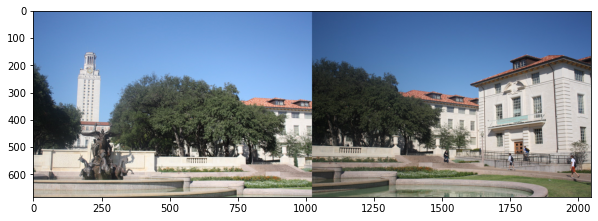

In [5]:
image1 = np.asarray(Image.open('Data/uttower_left.jpg'))
image2 = np.asarray(Image.open('Data/uttower_right.jpg'))
plot = display_color(np.concatenate((image1, image2), axis=1))

In [6]:
def run_sift(image, num_features):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create(num_features)
    
    kp, des = sift.detectAndCompute(gray, None) 
    
    return kp[0:num_features], des[0:num_features]

In [7]:
def l2_distance(p1: np.array, p2: np.array):
    return np.linalg.norm(p1 - p2, ord=2)

def find_sift_correspondences(kp1, des1, kp2, des2, ratio):
    
    corres = [] 
    
    for i in range(len(kp1)):
        distances = []
        for j in range(len(kp2)): 
            #Find distances between every first image's descriptor and second image's descriptor
            distance = l2_distance(des1[i], des2[j])
            distances.append(distance)
        
        #Sort distances 
        sorted_distances = np.argsort(distances)
        #sorted(range(len(sorted_distances)), key=lambda k:sorted_distances[k])
        
        #Find des' and des"
        des_1 = des2[sorted_distances[0]]
        des_2 = des2[sorted_distances[1]]
        
        #Find kp' and kp"
        keypoint1 = kp2[sorted_distances[0]]
        keypoint2 = kp2[sorted_distances[1]]
        
        #Check for possible correspondence
        possible_correspondence = l2_distance(des1[i], des_1) < ratio * l2_distance(des1[i], des_2)
        
        if possible_correspondence:
            #Append kp and kp'
            corres.append((kp1[i].pt, keypoint1.pt))
    
    return corres
    

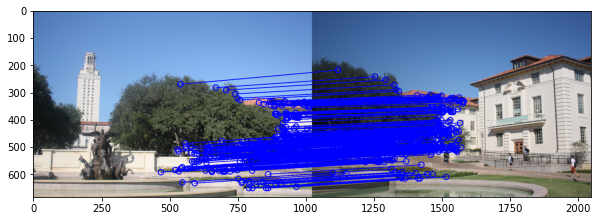

In [8]:
kp1, des1 = run_sift(image1, 2000)
kp2, des2 = run_sift(image2, 2000)
correspondences = find_sift_correspondences(kp1, des1, kp2, des2, 0.6)
plot = plot_correspondences(image1, image2, correspondences, (0, 0, 255))
os.makedirs('Data/Solutions', exist_ok=True)
plot.savefig('Data/Solutions/corres.pdf', format='pdf', bbox_inches='tight')

In [9]:
def compute_homography(correspondences):
    
    stacked = np.zeros((0,9))
    
    for i in range(len(correspondences)):
        
        x = correspondences[i][0][0]
        #print(x)
        y = correspondences[i][0][1]
        #print(y)
        x_prime = correspondences[i][1][0]
        #print(x_prime)
        y_prime = correspondences[i][1][1]
        #print(y_prime)
        
        A = np.array([[-x, -y, -1, 0, 0, 0, x*x_prime, y*x_prime, x_prime], 
                     [0, 0, 0, -x, -y, -1, x*y_prime, y*y_prime, y_prime]])
        
        
        stacked = np.vstack((stacked, A))
        
        
    u,s,vh = np.linalg.svd(stacked)    
        
    h = np.zeros((3,3))
    for i in range(3): 
        for j in range(3): 
            h[i][j] = vh[8][3*i + j] 
    
    
    return h
    

In [10]:
def apply_homography(points, homography):
    
    array = []
    result = []
    post_homography = []
    
    #Append 2D points in homogeneous coordinates
    for i in range(len(points)):
        array.append([points[i][0], points[i][1], 1])
    
    #Applying homography 
    for i in range(len(array)):
        mult = np.matmul(homography, array[i])
        post_homography.append(mult)
    
    #Convert back into heterogeneous coordinates 
    for i in range(len(post_homography)):
        constant = post_homography[i][2]
        result.append([post_homography[i][0]/constant, post_homography[i][1]/constant])
        
    return result
   

In [11]:
def compute_inliers(homography, correspondences, threshold):
    
    p1 = []
    p1_prime = []
    
    inliers = [] 
    outliers = []
    
    #Get each points 
    for i in range(len(correspondences)):
        p1.append(correspondences[i][0])
        p1_prime.append(correspondences[i][1])
        
    #Apply homography to obtain HP1 
    post_homography = apply_homography(p1, homography)
    
    #Loop
    for i in range(len(post_homography)):
        
        HP1 = np.array(post_homography[i])
        p_prime = np.array(p1_prime[i])
        
        #Compare Euclidian distance with threshold
        if(l2_distance(HP1, p_prime) < threshold): 
            
            #Append to inliers if distance is within threshold
            inliers.append([p1[i], p1_prime[i]])
        else: 
            
            #Append to outliers otherwise
            outliers.append([p1[i], p1_prime[i]])
        
    
    return inliers, outliers
    

In [12]:
def ransac(correspondences, num_iterations, num_sampled_points, threshold):
    
    max_inliers = 0
    answer_homography =[]
    answer_inliers =[]
    answer_outliers = []
    
    #Looping through num_iterations
    for i in range(num_iterations):
        
        #Shuffle 
        random.shuffle(correspondences)
        
        #Get num_sampled_points correspondences
        sample_points = correspondences[:num_sampled_points]
        
        #Compute Homography using DLT
        homography_matrix = compute_homography(sample_points)
    
        #Compute inliers 
        inliers, outliers = compute_inliers(homography_matrix, sample_points, threshold)

        #If len > max, return 
        if(len(inliers) > max_inliers):
            max_inliers = len(inliers)
            answer_homography = homography_matrix
            answer_inliers = inliers
            answer_outliers = outliers
            
    answer_inliers, answer_outliers = compute_inliers(answer_homography, correspondences, threshold)
    
    return answer_homography, answer_inliers, answer_outliers
    

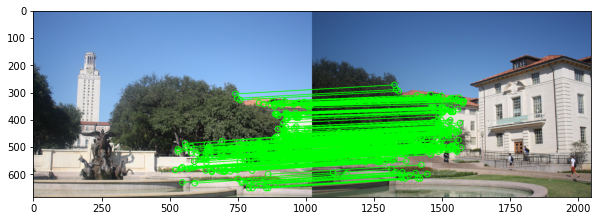

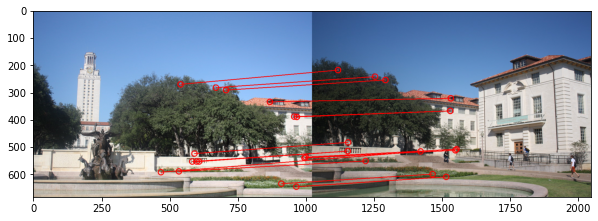

In [13]:
_, inliers, outliers = ransac(correspondences, 50, 6, 3)
inliers_plot = plot_correspondences(image1, image2, inliers, (0, 255, 0))
inliers_plot.savefig('Data/Solutions/inliers.pdf', format='pdf', bbox_inches='tight')
outliers_plot = plot_correspondences(image1, image2, outliers, (255, 0, 0))
outliers_plot.savefig('Data/Solutions/outliers.pdf', format='pdf', bbox_inches='tight')

In [14]:
def interpolate(image, loc):
    
    max_height = image.shape[0]
    max_width  = image.shape[1]
    
    x_delta_x = loc[0]
    y_delta_y = loc[1]
    
    x = int(x_delta_x//1)
    y = int(y_delta_y//1)
    
    delta_x = x_delta_x - x
    delta_y = y_delta_y - y
    
    I_delta_x_y = image[y,x]*(1-delta_x) + image[y,x+1]*delta_x
    I_delta_x_y_1 = image[y+1,x]*(1-delta_x) + image[y+1,x+1]*delta_x
    
    I_delta_delta = I_delta_x_y*(1-delta_y) + I_delta_x_y_1*(delta_y)
    
    return I_delta_delta

In [15]:
def stitch_image_given_H(image1, image2, homography):
    
    H_inverse = (np.linalg.inv(homography))
    
    #Ranges
    image1_h = image1.shape[0]
    image1_w = image1.shape[1]
    
    image2_h = image2.shape[0]
    image2_w = image2.shape[1]
    
    #Pad image1 with image2
    image1_padded = np.pad(image1, [(0, 0), (0, image2_w), (0,0)], mode = 'constant', constant_values = (0,0))
    image1_padded_h = image1_padded.shape[0]
    image1_padded_w = image1_padded.shape[1]
    
    #Loop through every pixels in image2
    for j in range(image1_h):
        for i in range(image1_w + image1_w):
            
            #Convert into homogeneous
            p1_homogeneous = np.array([i,j,1])
            
            #Apply homography to find p2 location
            p2_homogeneous = np.matmul(homography, p1_homogeneous)
            p2_heterogeneous = p2_homogeneous[0:2]/p2_homogeneous[2]
            
            #Get p2's x and y values
            p2_x = p2_heterogeneous[0]
            p2_y = p2_heterogeneous[1]
            
            #If p2 is within bounds
            if(p2_x < image2_w-1 and p2_y < image2_h-1 and p2_x > 0 and p2_y > 0):
                
                #p2 might not be an integer, apply bil. interpolation
                I_p2_inter = interpolate(image2, p2_heterogeneous)
                
                #Take average if there is an existing pixel value
                if(np.all(image1_padded[j][i]) != 0):
                    image1_padded[j][i] = (image1_padded[j][i] + I_p2_inter)/2
                
                else: 
                    image1_padded[j][i] = I_p2_inter
                    
            else: 
                
                image1_padded[j][i] = image1_padded[j][i]
    
    return image1_padded
                
    

In [16]:
def stitch_image(image1, image2, num_features, sift_ratio, ransac_iter, ransac_sampled_points, inlier_threshold, use_ransac=True):
    
    #Get keypoints and descriptors
    kp1, des1 = run_sift(image1, num_features)
    kp2, des2 = run_sift(image2, num_features)
    
    #Get correspondences
    correspondences = find_sift_correspondences(kp1, des1, kp2, des2, sift_ratio)
    
    #Apply ransac if required
    if(use_ransac):
        _, inliers, outliers = ransac(correspondences, ransac_iter, ransac_sampled_points, inlier_threshold)
        
        #Recompute homography after obtaining list of inliers
        answer_homography = compute_homography(inliers)
    else: 
        
        #Compute homography from correspondences
        answer_homography = compute_homography(correspondences)
    
    #Obtain stitched image
    stitched_image = stitch_image_given_H(image1, image2, answer_homography)
    
    return stitched_image

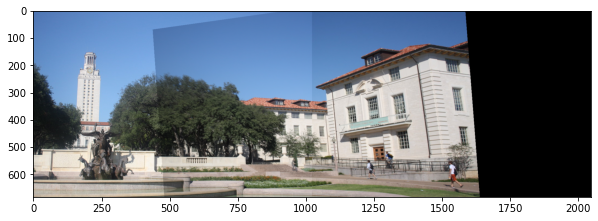

In [17]:
stitched_image = stitch_image(image1, image2, 2000, 0.6, 50, 6, 3)
stitched_plot = display_color(stitched_image / 255.0)
stitched_plot.savefig('Data/Solutions/ransacstitched.pdf', format='pdf', bbox_inches='tight')

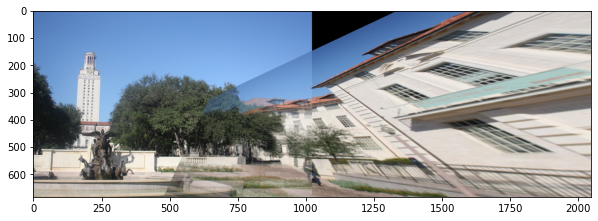

In [18]:
stitched_image = stitch_image(image1, image2, 2000, 0.6, 50, 6, 3, False)
stitched_plot = display_color(stitched_image / 255.0)
stitched_plot.savefig('Data/Solutions/nonransac.pdf', format='pdf', bbox_inches='tight')

### Olympic Champion Using Homography

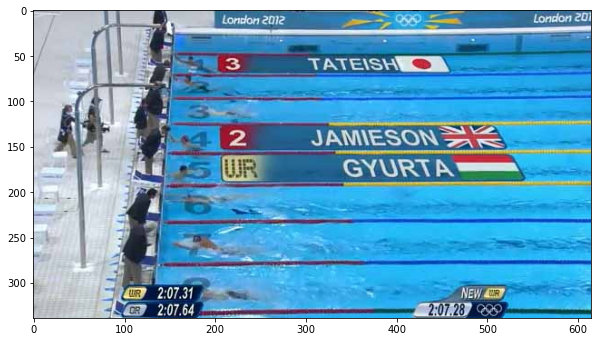

In [19]:
img = np.asarray(Image.open('Data/pool-vfx.jpg'))
_ = display_color(img/255.0)

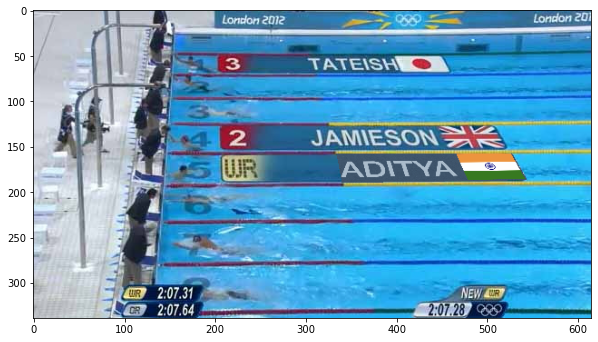

In [20]:
img_final = Image.open('Data/pool.png')
display(img_final)

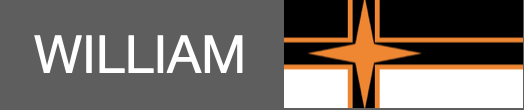

In [21]:
name_img = Image.open('Data/name_image.png')

display(name_img)

name_img = np.asarray(Image.open('Data/name_image.png').convert('RGB'))

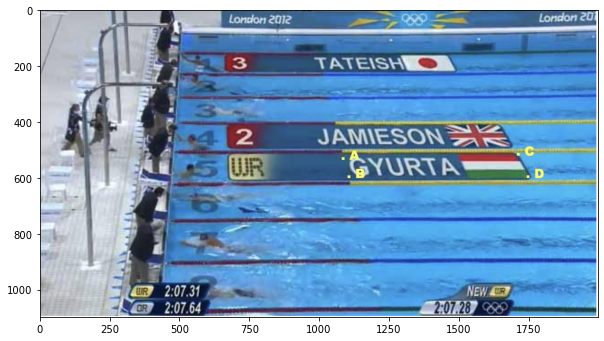

In [22]:
cp = np.asarray(Image.open('Data/Corresponding_points.png'))
_ = display_color(cp/255.0)

In [23]:
# Fill in the values for the corresponding points for your name+flag image.

A_1 = [0,0]
B_1 = [0,109]
C_1 = [523,0]
D_1 = [523,109]
correspondence = [
                  ([334,158], A_1),
                  ([340,190], B_1),
                  ([528,157], C_1),
                  ([545,187], D_1),
]


In [24]:
homography = compute_homography(correspondence)

In [25]:
def stitch_image_given_H_new(pool_image, name_flag_image, homography):
    
    #Make a copy of final image 
    
    final_image = np.copy(pool_image)
    
    H_inverse = (np.linalg.inv(homography))
    
    #Ranges
    pool_image_h = pool_image.shape[0]
    pool_image_w = pool_image.shape[1]
    
    name_flag_image_h = name_flag_image.shape[0]
    name_flag_image_w = name_flag_image.shape[1]
    
    #Loop through every pixels in image2
    for j in range(pool_image_h):
        for i in range(pool_image_w):
            
            #Convert into homogeneous
            p1_homogeneous = np.array([i,j,1])
            
            #Apply homography to find p2 location
            p2_homogeneous = np.matmul(homography, p1_homogeneous)
            p2_heterogeneous = p2_homogeneous[0:2]/p2_homogeneous[2]
            
            #Get p2's x and y values
            p2_x = p2_heterogeneous[0]
            p2_y = p2_heterogeneous[1]
            
            #If p2 is within bounds
            if(p2_x < name_flag_image_w-1 and p2_y < name_flag_image_h-1 and p2_x > 0 and p2_y > 0):
                
                #p2 might not be an integer, apply bil. interpolation
                I_p2_inter = interpolate(name_flag_image, p2_heterogeneous)
        
                final_image[j][i] = I_p2_inter
                    
    
    return final_image
                

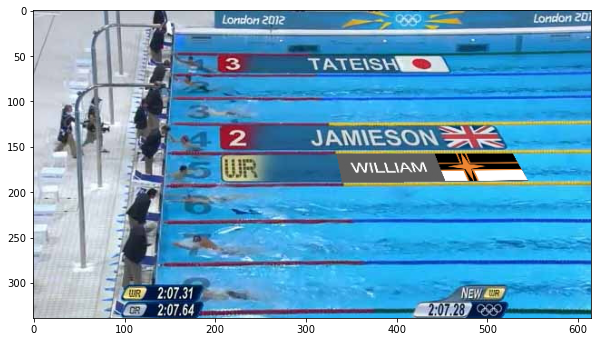

In [26]:
new_olympic_champion = stitch_image_given_H_new(img, name_img, homography)
plot = display_color(new_olympic_champion,True)
os.makedirs('Data/Solutions', exist_ok=True)
plot.savefig('Data/Solutions/champ.png', format='png', bbox_inches='tight')